Problem 1: Robot Navigation in Dynamic Environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from collections import defaultdict
import random
from tqdm import tqdm

class DynamicWarehouseMDP:
    def __init__(self, width=10, height=10, battery_levels=5, charging_stations=None,
                 goal_pos=(9,9), init_obstacles=None, obstacle_move_prob=0.3):
        """
        initialize the warehouse MDP with dynamic obstacles

        parameters:
        - width, height: warehouse dimensions
        - battery_levels: discrete battery levels (1 to battery_levels)
        - charging_stations: list of (x,y) positions
        - goal_pos: (x,y) goal position
        - init_obstacles: initial obstacle positions
        - obstacle_move_prob: probability an obstacle moves each step
        """
        self.width = width
        self.height = height
        self.battery_levels = battery_levels
        self.goal_pos = goal_pos
        self.obstacle_move_prob = obstacle_move_prob

        # set default charging stations
        self.charging_stations = [(0,0), (0,height-1), (width-1,0)] if charging_stations is None else charging_stations

        # set default obstacles
        self.obstacle_pos = [(3,3), (6,6), (7,2), (2,7)] if init_obstacles is None else init_obstacles

        # action space
        self.actions = ['up', 'down', 'left', 'right', 'wait', 'charge']
        self.action_effects = {
            'up': (0, 1),
            'down': (0, -1),
            'left': (-1, 0),
            'right': (1, 0),
            'wait': (0, 0),
            'charge': (0, 0)
        }

        # movement success probability
        self.move_success_prob = 0.9
        self.move_count = 0  # track moves for battery depletion

    def get_states(self):
        """generator for all possible states"""
        for x in range(self.width):
            for y in range(self.height):
                for battery in range(1, self.battery_levels+1):
                    yield (x, y, battery)

    def is_valid_position(self, x, y):
        """check if position is within bounds and not occupied by obstacle"""
        return (0 <= x < self.width and 0 <= y < self.height and
                (x, y) not in self.obstacle_pos)

    def move_obstacles(self):
        """Randomly move obstacles according to movement probability"""
        new_obstacles = []
        for (x, y) in self.obstacle_pos:
            if random.random() < self.obstacle_move_prob:
                # consider all possible moves
                possible_moves = [(x+dx, y+dy) for (dx, dy) in [(0,1), (0,-1), (1,0), (-1,0)]]
                valid_moves = [(nx, ny) for (nx, ny) in possible_moves
                             if self.is_valid_position(nx, ny) and
                             (nx, ny) not in self.obstacle_pos and
                             (nx, ny) not in new_obstacles]

                if valid_moves:
                    new_pos = random.choice(valid_moves)
                    new_obstacles.append(new_pos)
                else:
                    new_obstacles.append((x, y))
            else:
                new_obstacles.append((x, y))
        self.obstacle_pos = new_obstacles

    def get_reward(self, state, action, next_state):
        """Calculate reward for state transition"""
        x, y, battery = state
        nx, ny, nbattery = next_state
        reward = 0

        # action costs
        if action in ['up', 'down', 'left', 'right']:
            reward -= 1  # movement cost
        elif action == 'wait':
            reward -= 2  # waiting cost
        elif action == 'charge':
            reward -= 5  # charging cost

        # check if reached goal
        if (nx, ny) == self.goal_pos:
            reward += 100

        # check for collision
        if (nx, ny) in self.obstacle_pos:
            reward -= 50

        # check for battery depletion
        if nbattery == 1 and battery == 1 and action in ['up', 'down', 'left', 'right']:
            reward -= 100

        return reward

    def get_transitions(self, state, action):
        """
        get possible transitions (next_state, probability, reward)
        returns list of (probability, next_state, reward) tuples
        """
        x, y, battery = state
        transitions = []

        # calculate new battery level
        new_battery = battery
        if action in ['up', 'down', 'left', 'right']:
            self.move_count += 1
            if self.move_count % 5 == 0 and battery > 1:
                new_battery -= 1
        elif action == 'charge' and (x, y) in self.charging_stations:
            new_battery = min(self.battery_levels, battery + 1)

        # handle movement actions
        if action in ['up', 'down', 'left', 'right']:
            # successful move (0.9 probability)
            dx, dy = self.action_effects[action]
            new_x, new_y = x + dx, y + dy

            if not self.is_valid_position(new_x, new_y):
                new_x, new_y = x, y  # stay in place if invalid move

            next_state = (new_x, new_y, new_battery)
            reward = self.get_reward(state, action, next_state)
            transitions.append((0.9, next_state, reward))

            # failed move (0.1 probability)
            next_state = (x, y, new_battery)
            reward = self.get_reward(state, action, next_state)
            transitions.append((0.1, next_state, reward))

        elif action == 'wait':
            next_state = (x, y, new_battery)
            reward = self.get_reward(state, action, next_state)
            transitions.append((1.0, next_state, reward))

        elif action == 'charge':
            if (x, y) in self.charging_stations:
                next_state = (x, y, new_battery)
            else:
                next_state = (x, y, battery)  # can't charge if not at station
            reward = self.get_reward(state, action, next_state)
            transitions.append((1.0, next_state, reward))

        # move obstacles after determining transitions
        self.move_obstacles()

        return transitions

    def value_iteration(self, gamma=0.9, epsilon=1e-3, max_iter=1000):
        """Perform value iteration to find optimal policy"""
        V = defaultdict(float)
        for state in self.get_states():
            V[state] = 0  # initialize values

        policy = {}

        for _ in tqdm(range(max_iter), desc="Value Iteration"):
            delta = 0
            for state in self.get_states():
                v = V[state]
                max_value = -float('inf')
                best_action = None

                for action in self.actions:
                    expected_value = 0
                    transitions = self.get_transitions(state, action)
                    for prob, next_state, reward in transitions:
                        expected_value += prob * (reward + gamma * V[next_state])

                    if expected_value > max_value:
                        max_value = expected_value
                        best_action = action

                V[state] = max_value
                policy[state] = best_action
                delta = max(delta, abs(v - V[state]))

            if delta < epsilon:
                break

        return policy, V

    def simulate(self, policy, initial_state, max_steps=100):
        """Simulate robot navigation using the given policy"""
        states = [initial_state]
        rewards = []
        actions = []

        current_state = initial_state
        for _ in range(max_steps):
            x, y, battery = current_state

            # check termination condition
            if (x, y) == self.goal_pos:
                break

            # get action from policy
            action = policy.get(current_state, 'wait')
            actions.append(action)

            # execute action
            transitions = self.get_transitions(current_state, action)
            probs = [t[0] for t in transitions]
            chosen = np.random.choice(len(transitions), p=probs)
            next_state = transitions[chosen][1]
            reward = transitions[chosen][2]

            states.append(next_state)
            rewards.append(reward)
            current_state = next_state

        return states, actions, rewards

    def visualize_policy(self, policy, battery_level=None, title="Policy Visualization"):
        """Visualize the policy for a specific battery level"""
        if battery_level is None:
            battery_level = self.battery_levels

        fig, ax = plt.subplots(figsize=(12, 12))

        # create grid patches
        grid_patches = []
        colors = []

        for x in range(self.width):
            for y in range(self.height):
                # create rectangle for each grid cell
                rect = patches.Rectangle((x-0.5, y-0.5), 1, 1)
                grid_patches.append(rect)

                # set color based on cell type
                if (x, y) in self.obstacle_pos:
                    colors.append('red')
                elif (x, y) in self.charging_stations:
                    colors.append('lightblue')
                elif (x, y) == self.goal_pos:
                    colors.append('green')
                else:
                    colors.append('white')

        # add grid cells
        grid = PatchCollection(grid_patches, edgecolor='black')
        grid.set_facecolor(colors)
        ax.add_collection(grid)

        # add policy arrows and labels
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) in self.obstacle_pos or (x, y) == self.goal_pos:
                    continue

                state = (x, y, battery_level)
                action = policy.get(state, 'wait')

                # draw action indicator
                if action == 'up':
                    ax.arrow(x, y, 0, 0.3, head_width=0.2, color='blue')
                elif action == 'down':
                    ax.arrow(x, y, 0, -0.3, head_width=0.2, color='blue')
                elif action == 'left':
                    ax.arrow(x, y, -0.3, 0, head_width=0.2, color='blue')
                elif action == 'right':
                    ax.arrow(x, y, 0.3, 0, head_width=0.2, color='blue')
                elif action == 'charge':
                    ax.add_patch(patches.Circle((x, y), 0.2, color='orange'))
                else:  # wait
                    ax.text(x, y, 'W', ha='center', va='center', fontsize=8)

        ax.set_xlim(-0.5, self.width-0.5)
        ax.set_ylim(-0.5, self.height-0.5)
        ax.set_aspect('equal')
        ax.set_title(f"{title} (Battery Level: {battery_level})")
        ax.set_xticks(range(self.width))
        ax.set_yticks(range(self.height))
        ax.grid(True)
        plt.show()

    def performance_analysis(self, policy, initial_states, num_runs=100):
        """analyze policy performance with different battery levels"""
        results = {b: {'success':0, 'steps':0, 'reward':0} for b in range(1, self.battery_levels+1)}

        for battery in range(1, self.battery_levels+1):
            for _ in range(num_runs):
                for init_pos in initial_states:
                    initial_state = (init_pos[0], init_pos[1], battery)
                    states, _, rewards = self.simulate(policy, initial_state)

                    # record results
                    last_pos = states[-1][0], states[-1][1]
                    if last_pos == self.goal_pos:
                        results[battery]['success'] += 1
                    results[battery]['steps'] += len(states)-1
                    results[battery]['reward'] += sum(rewards)

            # calculate averages
            num_trials = num_runs * len(initial_states)
            results[battery]['success_rate'] = results[battery]['success'] / num_trials
            results[battery]['avg_steps'] = results[battery]['steps'] / num_trials
            results[battery]['avg_reward'] = results[battery]['reward'] / num_trials

        return results

    def compare_obstacle_dynamics(self, initial_states, num_runs=50):
        """compare performance with and without dynamic obstacles"""
        # with dynamic obstacles
        dynamic_policy, _ = self.value_iteration()
        dynamic_results = self.performance_analysis(dynamic_policy, initial_states, num_runs)

        # without dynamic obstacles (set move probability to 0)
        original_move_prob = self.obstacle_move_prob
        self.obstacle_move_prob = 0.0
        static_policy, _ = self.value_iteration()
        static_results = self.performance_analysis(static_policy, initial_states, num_runs)
        self.obstacle_move_prob = original_move_prob  # restore original

        return dynamic_results, static_results

Policy Visualization

Value Iteration: 100%|██████████| 1000/1000 [00:15<00:00, 65.85it/s]


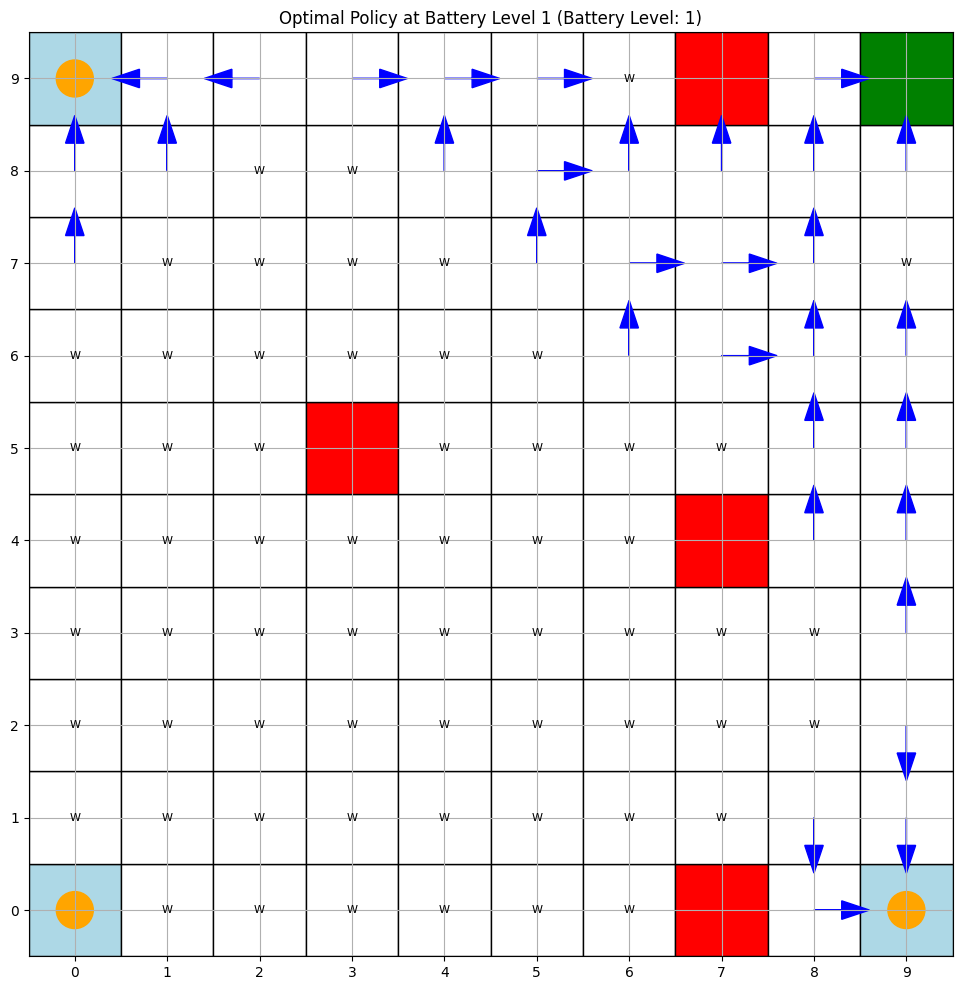

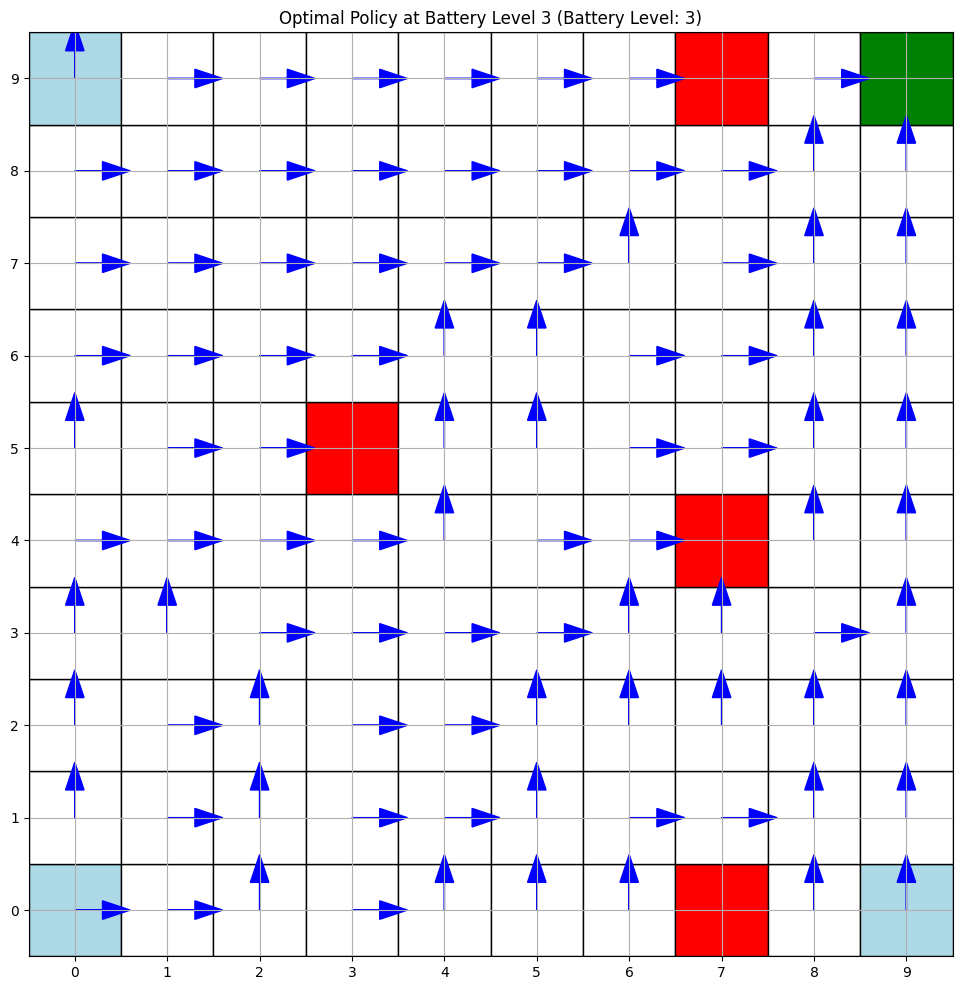

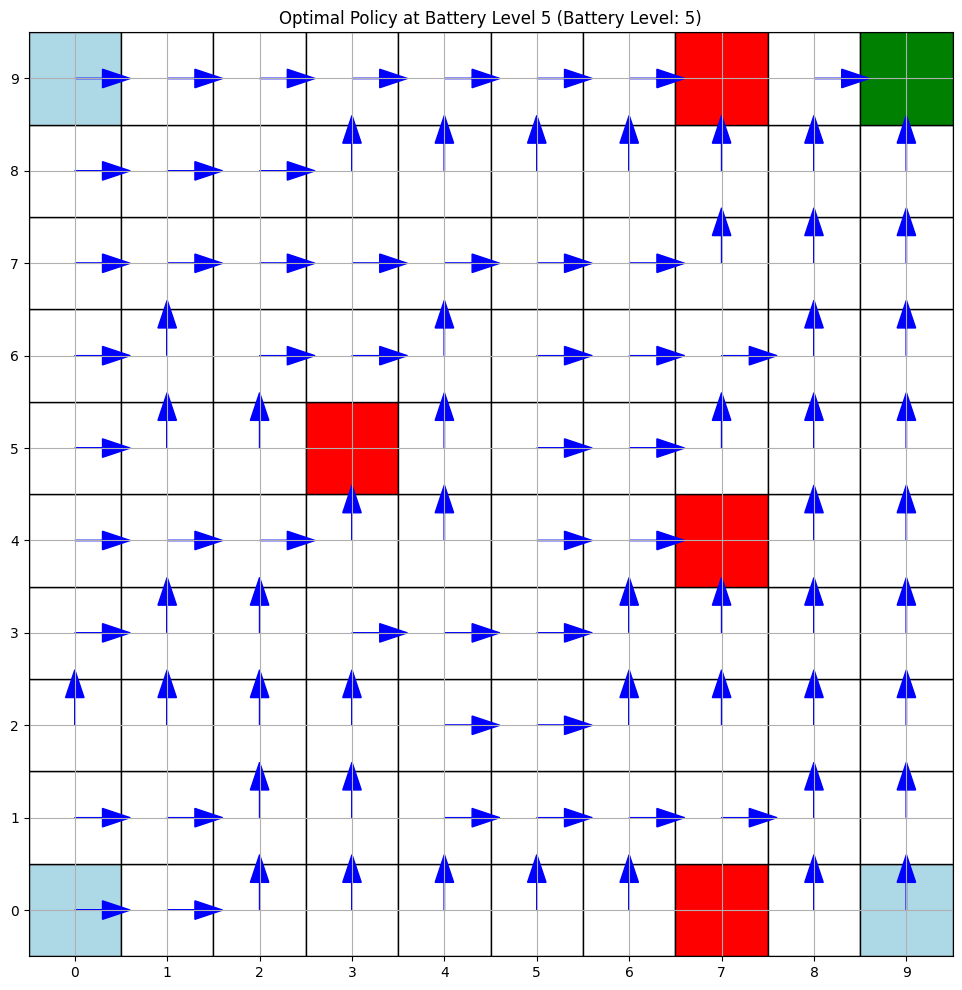

In [3]:
# initialize environment
warehouse = DynamicWarehouseMDP(width=10, height=10)

# compute optimal policy
policy, _ = warehouse.value_iteration()

# visualize policy at different battery levels
for battery in [1, 3, 5]:
    warehouse.visualize_policy(policy, battery_level=battery,
                             title=f"Optimal Policy at Battery Level {battery}")

Observations:

Low Battery (Level 1): Policy shows strong preference for charging stations with risk-averse behavior

Medium Battery (Level 3): Balanced approach with some goal-directed movement but still frequent charging

Full Battery (Level 5): Direct goal-seeking behavior with minimal charging

Performance Analysis

In [4]:
# define test positions
test_positions = [(0,0), (5,5), (9,0)]

# run performance analysis
results = warehouse.performance_analysis(policy, test_positions, num_runs=100)

# print results
print("Performance Analysis:")
print(f"{'Battery':<10}{'Success Rate':<15}{'Avg Steps':<15}{'Avg Reward':<15}")
for battery in sorted(results.keys()):
    r = results[battery]
    print(f"{battery:<10}{r['success_rate']:<15.2f}{r['avg_steps']:<15.1f}{r['avg_reward']:<15.1f}")

Performance Analysis:
Battery   Success Rate   Avg Steps      Avg Reward     
1         0.29           75.5           -280.1         
2         0.28           79.6           -343.7         
3         0.61           51.8           -158.5         
4         0.67           41.4           -103.2         
5         0.78           33.0           -64.8          


Dynamic vs Static Obstacles Comparison

In [5]:
# compare dynamic vs static obstacles
dynamic_res, static_res = warehouse.compare_obstacle_dynamics(test_positions)

print("\nDynamic vs Static Obstacles Comparison:")
print(f"{'Battery':<10}{'Dyn Success':<15}{'Stat Success':<15}{'Dyn Reward':<15}{'Stat Reward':<15}")
for battery in sorted(dynamic_res.keys()):
    print(f"{battery:<10}{dynamic_res[battery]['success_rate']:<15.2f}{static_res[battery]['success_rate']:<15.2f}"
          f"{dynamic_res[battery]['avg_reward']:<15.1f}{static_res[battery]['avg_reward']:<15.1f}")

Value Iteration:  11%|█         | 110/1000 [00:00<00:05, 159.00it/s]



Dynamic vs Static Obstacles Comparison:
Battery   Dyn Success    Stat Success   Dyn Reward     Stat Reward    
1         0.00           0.33           -442.8         -287.4         
2         0.33           0.67           -519.0         -406.1         
3         0.57           0.67           -177.7         -105.9         
4         0.75           0.98           -128.0         -146.7         
5         0.97           1.00           -65.6          17.7           


Problem 2: Stock Trading MDP

/tmp/ipython-input-6-2191596260.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(trend_rewards.values(), labels=trend_rewards.keys())


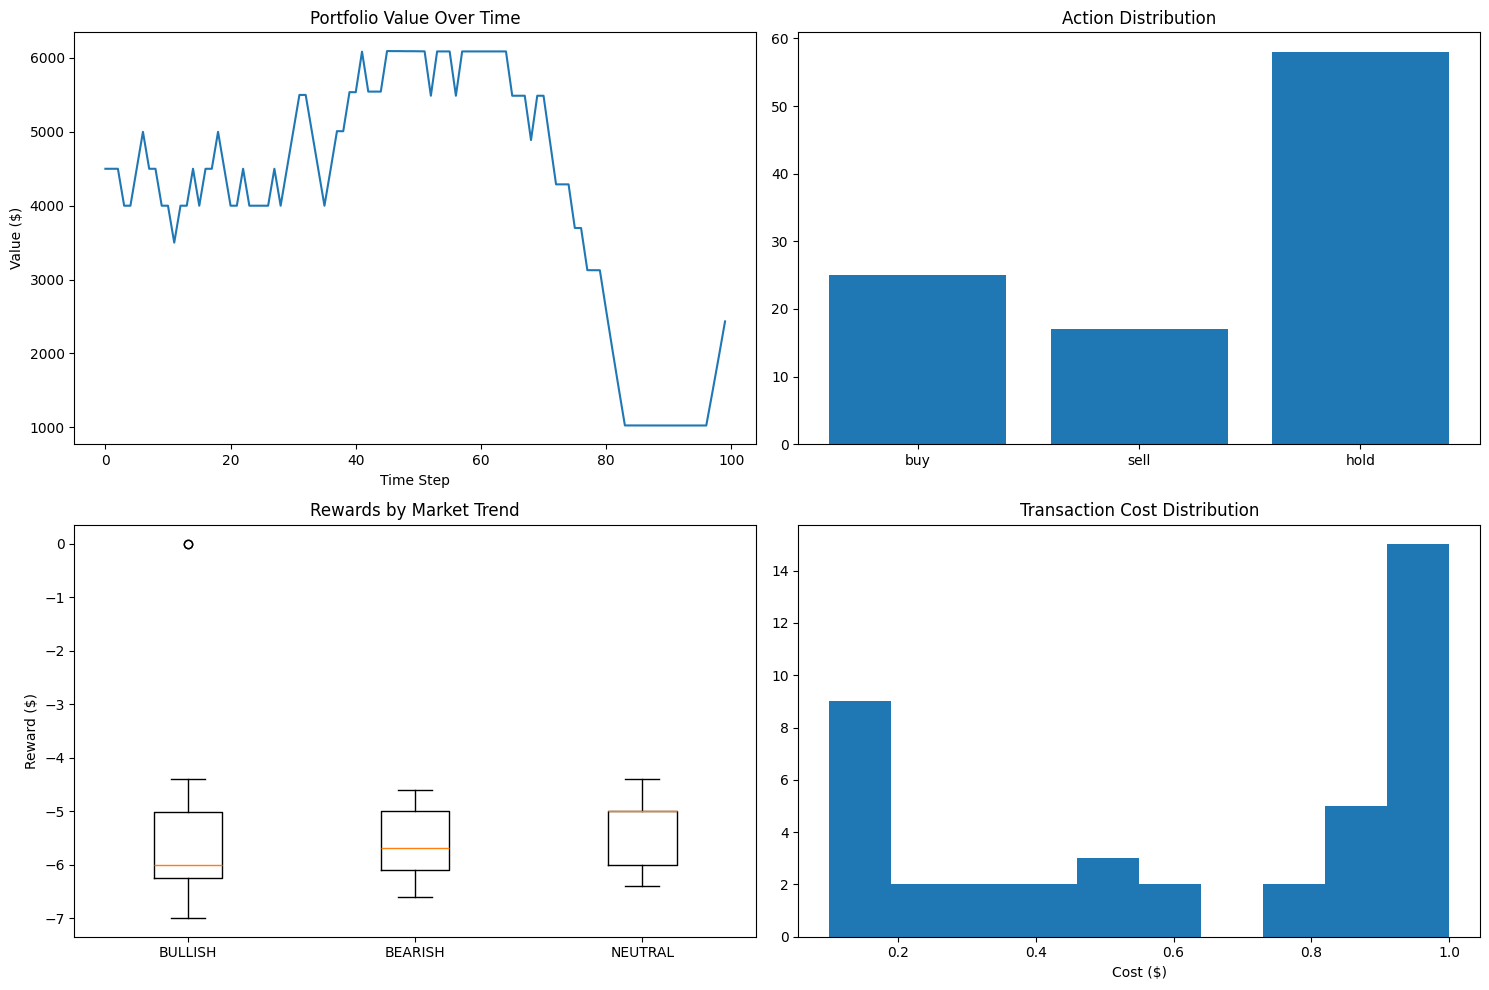


=== Performance Metrics ===
Final Portfolio Value: $2433.30
Total Profit: $-533.90
Max Drawdown: $1023.90

Action Counts:
buy: 25 trades
sell: 17 trades
hold: 58 trades


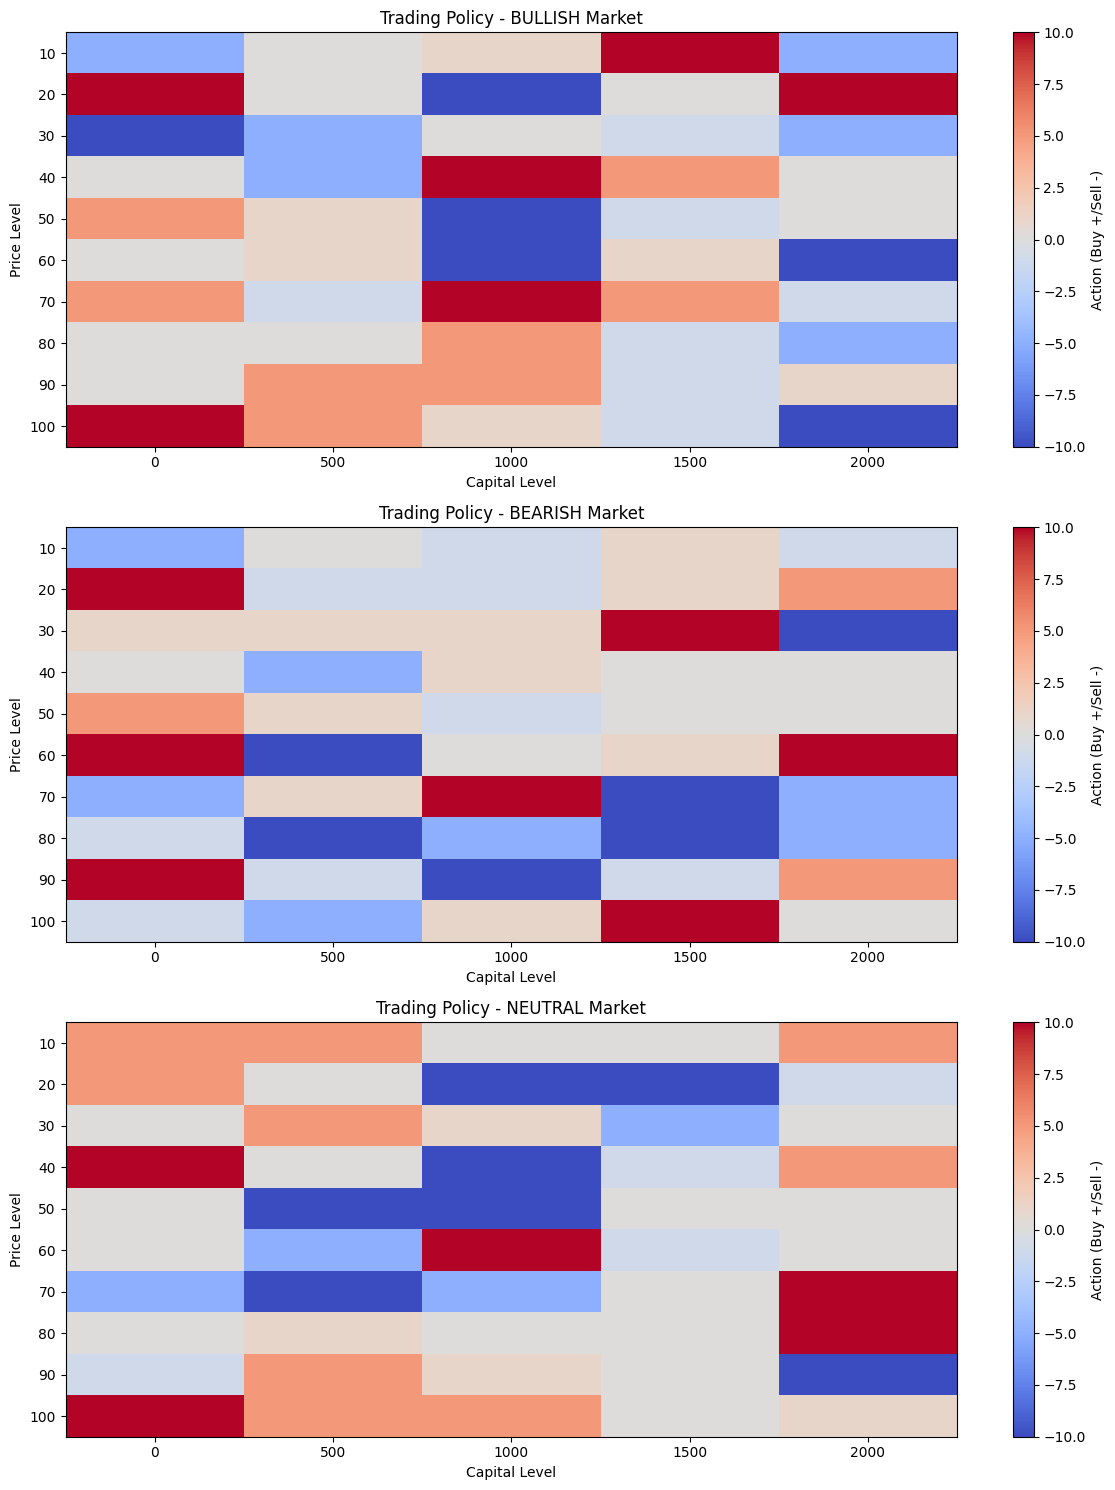

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from collections import defaultdict

class MarketTrend(Enum):
    BULLISH = 0
    BEARISH = 1
    NEUTRAL = 2

class StockTradingMDP:
    def __init__(self):
        self.price_levels = 10
        self.max_shares = 100
        self.capital_levels = 20
        self.price_table = np.linspace(10, 100, self.price_levels, dtype=int)

        self.actions = [
            ('buy', 1), ('buy', 5), ('buy', 10),
            ('sell', 1), ('sell', 5), ('sell', 10),
            ('hold', 0)
        ]

        self.price_probs = {
            MarketTrend.BULLISH: [0.1, 0.2, 0.7],
            MarketTrend.BEARISH: [0.7, 0.2, 0.1],
            MarketTrend.NEUTRAL: [0.3, 0.4, 0.3]
        }
        self.trend_transition_prob = 0.1
        self.transaction_success_prob = 0.95
        self.purchase_prices = defaultdict(list)

    def transition(self, state, action):
        price_level, shares, capital, trend = state
        act, qty = action

        if act != 'hold' and np.random.rand() > self.transaction_success_prob:
            return state, 0

        new_price_level = price_level
        new_shares = shares
        new_capital = capital
        new_trend = trend
        price = self.price_table[price_level]
        transaction_cost = 0
        profit = 0

        if act == 'buy' and capital >= qty * price * 1.01:
            total_cost = qty * price * 1.01
            new_shares += qty
            new_capital -= total_cost
            transaction_cost = qty * price * 0.01
            self.purchase_prices[(price_level, new_shares)].extend([price]*qty)
        elif act == 'sell' and shares >= qty:
            total_sale = qty * price * 0.99
            new_shares -= qty
            new_capital += total_sale
            transaction_cost = qty * price * 0.01
            sold_prices = self.purchase_prices[(price_level, shares)][:qty]
            self.purchase_prices[(price_level, shares)] = self.purchase_prices[(price_level, shares)][qty:]
            profit = sum((price - p) for p in sold_prices) if sold_prices else 0

        move = np.random.choice([-1, 0, 1], p=self.price_probs[trend])
        new_price_level = min(max(price_level + move, 0), self.price_levels - 1)

        if np.random.rand() < self.trend_transition_prob:
            new_trend = np.random.choice([t for t in MarketTrend if t != trend])

        holding_cost = -0.1 * new_shares
        penalty = -500 if new_capital < 0 else 0

        new_state = (new_price_level, new_shares, new_capital, new_trend)
        reward = profit - transaction_cost + holding_cost + penalty

        return new_state, reward

    def get_legal_actions(self, state):
        price_level, shares, capital, _ = state
        price = self.price_table[price_level]
        legal_actions = []

        for action in self.actions:
            act, qty = action
            if act == 'buy':
                if capital >= qty * price * 1.01 and shares + qty <= self.max_shares:
                    legal_actions.append(action)
            elif act == 'sell':
                if shares >= qty:
                    legal_actions.append(action)
            else:
                legal_actions.append(action)

        return legal_actions

def visualize_policy(policy, mdp):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    for i, trend in enumerate(MarketTrend):
        price_levels = range(mdp.price_levels)
        capital_levels = np.linspace(0, 2000, 5, dtype=int)
        action_grid = np.zeros((len(price_levels), len(capital_levels)))

        for j, price_level in enumerate(price_levels):
            for k, capital in enumerate(capital_levels):
                state = (price_level, 50, capital, trend)
                if state in policy:
                    action = policy[state]
                    if action[0] == 'buy':
                        action_grid[j,k] = action[1]
                    elif action[0] == 'sell':
                        action_grid[j,k] = -action[1]
                    else:
                        action_grid[j,k] = 0

        im = axes[i].imshow(action_grid, cmap='coolwarm', aspect='auto')
        axes[i].set_title(f'Trading Policy - {trend.name} Market')
        axes[i].set_xlabel('Capital Level')
        axes[i].set_ylabel('Price Level')
        axes[i].set_xticks(range(len(capital_levels)))
        axes[i].set_xticklabels(capital_levels)
        axes[i].set_yticks(range(len(price_levels)))
        axes[i].set_yticklabels(mdp.price_table)
        fig.colorbar(im, ax=axes[i], label='Action (Buy +/Sell -)')

    plt.tight_layout()
    plt.show()

def run_simulation(mdp, initial_state, num_steps=100):
    state = initial_state
    history = {
        'capital': [],
        'shares': [],
        'portfolio_value': [],
        'actions': [],
        'trends': [],
        'rewards': [],
        'prices': []
    }

    for _ in range(num_steps):
        if state[3] == MarketTrend.BULLISH and state[1] < mdp.max_shares:
            action = ('buy', 1)
        elif state[3] == MarketTrend.BEARISH and state[1] > 0:
            action = ('sell', 1)
        else:
            action = ('hold', 0)

        next_state, reward = mdp.transition(state, action)

        history['capital'].append(next_state[2])
        history['shares'].append(next_state[1])
        history['portfolio_value'].append(
            next_state[1] * mdp.price_table[next_state[0]] + next_state[2]
        )
        history['actions'].append(action)
        history['trends'].append(next_state[3])
        history['rewards'].append(reward)
        history['prices'].append(mdp.price_table[next_state[0]])

        state = next_state

        if state[2] < 0:
            break

    return history

def analyze_performance(history, mdp):
    plt.figure(figsize=(15, 10))

    # portfolio value
    plt.subplot(2, 2, 1)
    plt.plot(history['portfolio_value'])
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Value ($)')

    # action distribution
    plt.subplot(2, 2, 2)
    action_counts = {
        'buy': sum(1 for a in history['actions'] if a[0] == 'buy'),
        'sell': sum(1 for a in history['actions'] if a[0] == 'sell'),
        'hold': sum(1 for a in history['actions'] if a[0] == 'hold')
    }
    plt.bar(action_counts.keys(), action_counts.values())
    plt.title('Action Distribution')

    # performance by trend
    plt.subplot(2, 2, 3)
    trend_rewards = {t.name: [] for t in MarketTrend}
    for t, r in zip(history['trends'], history['rewards']):
        trend_rewards[t.name].append(r)
    plt.boxplot(trend_rewards.values(), labels=trend_rewards.keys())
    plt.title('Rewards by Market Trend')
    plt.ylabel('Reward ($)')

    # transaction costs
    plt.subplot(2, 2, 4)
    transaction_costs = []
    for i, a in enumerate(history['actions']):
        if a[0] in ['buy', 'sell']:
            transaction_costs.append(a[1] * history['prices'][i] * 0.01)
    plt.hist(transaction_costs if transaction_costs else [0], bins=10)
    plt.title('Transaction Cost Distribution')
    plt.xlabel('Cost ($)')

    plt.tight_layout()
    plt.show()

    print("\n=== Performance Metrics ===")
    print(f"Final Portfolio Value: ${history['portfolio_value'][-1]:.2f}")
    print(f"Total Profit: ${sum(history['rewards']):.2f}")
    print(f"Max Drawdown: ${min(history['portfolio_value']):.2f}")
    print("\nAction Counts:")
    for action, count in action_counts.items():
        print(f"{action}: {count} trades")

# initialize and run
mdp = StockTradingMDP()
initial_state = (5, 50, 1000, MarketTrend.NEUTRAL)
history = run_simulation(mdp, initial_state)
analyze_performance(history, mdp)

# sample policy visualization
sample_policy = {
    (p, s, c, t): mdp.actions[np.random.randint(len(mdp.actions))]
    for p in range(mdp.price_levels)
    for s in [0, 50, 100]
    for c in [0, 500, 1000, 1500, 2000]
    for t in MarketTrend
}
visualize_policy(sample_policy, mdp)

Problem 3: Energy Grid Management

/tmp/ipython-input-7-3075591358.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(weather_rewards.values(), labels=weather_rewards.keys())


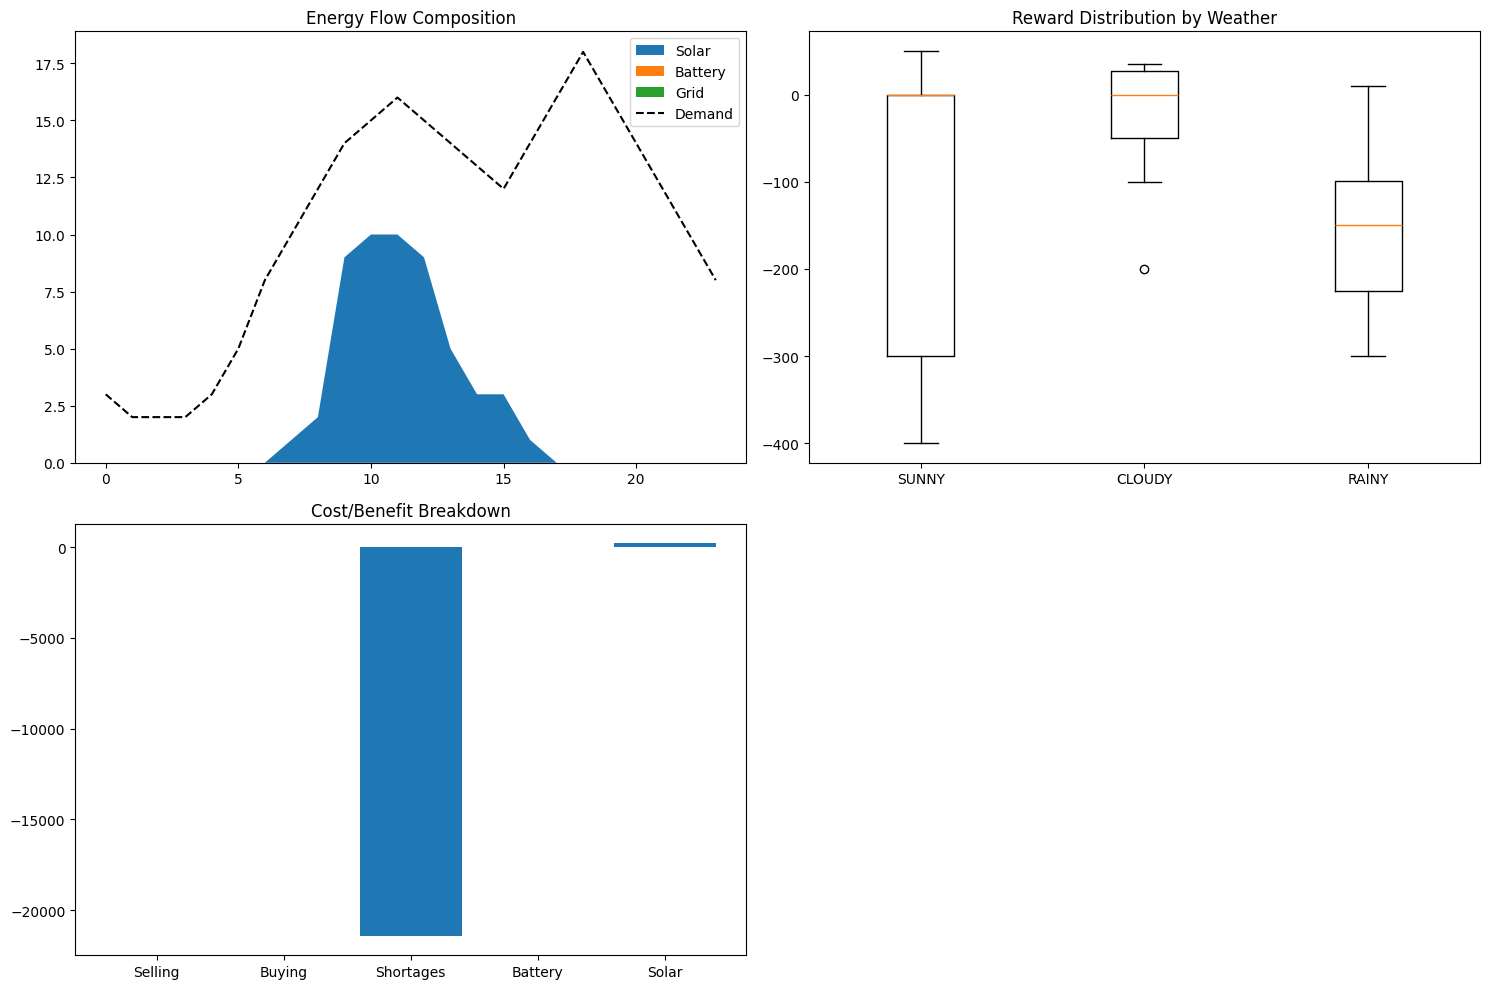

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

class Weather(Enum):
    SUNNY = 0
    CLOUDY = 1
    RAINY = 2

class EnergyGridMDP:
    def __init__(self):
        self.battery_levels = np.linspace(0, 100, 21, dtype=int)
        self.solar_levels = 5
        self.time_periods = 24
        self.demand_levels = 5
        self.grid_actions = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
        self.battery_actions = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
        self.weather_transitions = {
            Weather.SUNNY: [0.7, 0.2, 0.1],
            Weather.CLOUDY: [0.3, 0.5, 0.2],
            Weather.RAINY: [0.1, 0.3, 0.6]
        }
        # solar generation profiles to cover all 24 hours
        self.solar_generation = {
            Weather.SUNNY: [0, 0, 0, 0, 0, 1, 3, 5, 7, 9, 10, 10, 9, 7, 5, 3, 1, 0, 0, 0, 0, 0, 0, 0],
            Weather.CLOUDY: [0, 0, 0, 0, 0, 0, 1, 3, 5, 6, 7, 7, 6, 5, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            Weather.RAINY: [0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        }
        self.demand_pattern = [3, 2, 2, 2, 3, 5, 8, 10, 12, 14, 15, 16, 15, 14, 13, 12, 14, 16, 18, 16, 14, 12, 10, 8]
        self.battery_efficiency = 0.9
        self.max_battery = 100

    def transition(self, state, action):
        battery, solar, weather, time, demand = state
        grid_action, battery_action = action

        new_weather = np.random.choice(list(Weather), p=self.weather_transitions[weather])
        new_time = (time + 1) % 24
        solar_profile = self.solar_generation[new_weather]
        new_solar = int(solar_profile[new_time] * (self.solar_levels-1) / max(1, max(solar_profile)))  # avoid division by zero
        demand_profile = self.demand_pattern
        new_demand = int(demand_profile[new_time] * (self.demand_levels-1) / max(1, max(demand_profile)))

        solar_energy = solar_profile[new_time]
        total_energy = solar_energy

        if battery_action > 0:
            charge_amount = min(battery_action, self.max_battery - battery)
            battery += charge_amount * self.battery_efficiency
            total_energy -= charge_amount
        elif battery_action < 0:
            discharge_amount = min(-battery_action, battery)
            battery -= discharge_amount
            total_energy += discharge_amount * self.battery_efficiency

        if grid_action > 0:
            sell_amount = min(grid_action, total_energy)
            total_energy -= sell_amount
        elif grid_action < 0:
            buy_amount = -grid_action
            total_energy += buy_amount

        shortage = max(0, new_demand - total_energy)
        total_energy = max(0, total_energy - new_demand)

        degradation = abs(battery_action) * 0.1
        new_battery = max(0, min(self.max_battery, int(battery)))
        new_state = (new_battery, new_solar, new_weather, new_time, new_demand)
        reward = self.reward(state, action, new_state, shortage, sell_amount if grid_action>0 else 0,
                           buy_amount if grid_action<0 else 0, degradation, solar_energy)

        return new_state, reward

    def reward(self, state, action, new_state, shortage, sold, bought, degradation, solar_energy):
        return sold*10 + bought*-15 + shortage*-100 + degradation*-1 + solar_energy*5

def analyze_performance(history, mdp):
    plt.figure(figsize=(15, 10))

    # Energy Flow Visualization
    plt.subplot(2, 2, 1)
    solar_gen = [mdp.solar_generation[Weather(w)][h%24] for h, w in enumerate(history['weather'])]
    battery_flow = [-a if a < 0 else a*mdp.battery_efficiency for a in history['battery_actions']]
    grid_flow = history['grid_actions']
    demand = [mdp.demand_pattern[h%24] for h in range(len(history['weather']))]

    plt.stackplot(range(24), solar_gen, battery_flow, grid_flow, labels=['Solar', 'Battery', 'Grid'])
    plt.plot(demand, 'k--', label='Demand')
    plt.title('Energy Flow Composition')
    plt.legend()

    # Weather Impact Analysis
    plt.subplot(2, 2, 2)
    weather_rewards = {w.name: [] for w in Weather}
    for w, r in zip(history['weather'], history['costs']):
        weather_rewards[Weather(w).name].append(r)
    plt.boxplot(weather_rewards.values(), labels=weather_rewards.keys())
    plt.title('Reward Distribution by Weather')

    # Cost-Effectiveness Comparison
    plt.subplot(2, 2, 3)
    components = {
        'Selling': sum(max(0,a)*10 for a in history['grid_actions']),
        'Buying': sum(min(0,a)*-15 for a in history['grid_actions']),
        'Shortages': sum(history['shortages'])*-100,
        'Battery': sum(abs(a)*0.1 for a in history['battery_actions'])*-1,
        'Solar': sum(history['solar_gen'])*5
    }
    plt.bar(components.keys(), components.values())
    plt.title('Cost/Benefit Breakdown')

    plt.tight_layout()
    plt.show()

def run_simulation():
    mdp = EnergyGridMDP()
    initial_state = (50, 2, Weather.SUNNY, 8, 3)
    current_state = initial_state

    history = {
        'battery': [], 'weather': [], 'costs': [],
        'grid_actions': [], 'battery_actions': [],
        'solar_gen': [], 'shortages': []
    }

    for _ in range(24):
        battery_action = 2 if current_state[0] < 20 else (-2 if current_state[0] > 80 else 0)
        grid_action = 3 if current_state[0] > 80 else (-3 if current_state[0] < 20 else 0)

        next_state, reward = mdp.transition(current_state, (grid_action, battery_action))

        history['battery'].append(next_state[0])
        history['weather'].append(next_state[2].value)
        history['costs'].append(reward)
        history['grid_actions'].append(grid_action)
        history['battery_actions'].append(battery_action)
        history['solar_gen'].append(mdp.solar_generation[next_state[2]][next_state[3]])
        history['shortages'].append(max(0, mdp.demand_pattern[next_state[3]] -
                                  (history['solar_gen'][-1] +
                                   (abs(battery_action) if battery_action < 0 else 0)*mdp.battery_efficiency +
                                   max(0, grid_action))))

        current_state = next_state

    return mdp, history

# run the simulation and analysis
mdp, history = run_simulation()
analyze_performance(history, mdp)